# Lab 3: ATLAS Data Analysis
___

In [1]:
# Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.differentiate import derivative
from scipy.optimize import curve_fit
import scipy.stats as st
import matplotlib.cm as cm

# Constants
# Units: Gev/c^2
m_Z = 91.1880
m_Z_error = 0.0020

m_W = 80.3692
m_W_error = 0.0133

m_higgs = 125.20
m_higgs_error = 0.11

# Units: Mev/c^2
m_electron = 0.51099895000
m_electron_error = 0.00000000015

m_muon = 105.6583755
m_muon_error = 0.0000023

m_tau = 1776.93
m_tau_error = 0.09

# Part 1: The Invarient Mass Distribution
___

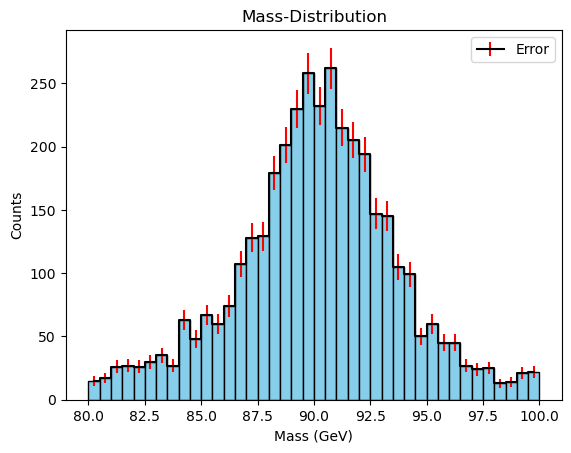

In [2]:
# (1) Loading and storing the ATLAS data in a variable
atlas_data = np.loadtxt('atlas_z_to_ll.csv', skiprows = 1, delimiter = ',')

# Storing each column of the data into a variable
pt1 = atlas_data[:,0]
pt2 = atlas_data[:,1]
eta1 = atlas_data[:,2]
eta2 = atlas_data[:,3]
phi1 = atlas_data[:,4]
phi2 = atlas_data[:,5]
E1 = atlas_data[:,6]
E2 = atlas_data[:,7]

# Defining function to find the mass of the particle
def find_m(pt1, pt2, eta1, eta2, phi1, phi2, E1, E2):
    # Calculating and adding the 3 momentum components
    px = (pt1 * np.cos(phi1)) + (pt2 * np.cos(phi2))
    py = (pt1 * np.sin(phi1)) + (pt2 * np.sin(phi2))
    pz = (pt1 * np.sinh(eta1)) + (pt2 * np.sinh(eta2))
    
    # Calculating the total momentum be squaring and adding the components
    total_p = px**2 + py**2 + pz**2
    # Calculating the total energy
    total_E = E1 + E2
    # Returning the mass
    return np.sqrt(total_E**2 - total_p)

# (2) Calculating the mass by using the function and inputting the ATLAS data
mass = find_m(pt1, pt2, eta1, eta2, phi1, phi2, E1, E2)

# Number of bins for the histogram
num_bins = np.linspace(80, 100, 41)

# Using 'np.hstogram' to find the counts and bins of the histogram
counts, bins = np.histogram(mass, bins = num_bins)
# Looking for center of each bar
bin_center = (bins[:-1] + bins[1:]) / 2
# Calculating error for each bins
error = np.sqrt(counts)

# (3) Plotting histogram of masses with errorbars
fig, ax_mass = plt.subplots(1, 1)
ax_mass.errorbar(bin_center, counts, yerr = error, color = 'black', ecolor = 'red', drawstyle = 'steps-mid', label = 'Error')
ax_mass.hist(mass, bins = num_bins, color = 'skyblue', edgecolor = 'black')
# Labeling the plots
ax_mass.set_xlabel("Mass (GeV)")
ax_mass.set_ylabel("Counts")
ax_mass.set_title("Mass-Distribution")
ax_mass.legend();

# Part 2: Breit-Wigner Fit
___

(4) 
Chi-Square: 9.985097164263694
Reduced Chi Square: 0.9985097164263694
P-Value: 0.4418017385627302

(5)
Best-Fit of True Rest Mass: 90.34080586027602 +/- 0.09351482708636819
Best-Fit of "Width" Parameter: 6.390998393703436 +/- 0.18107388027867127



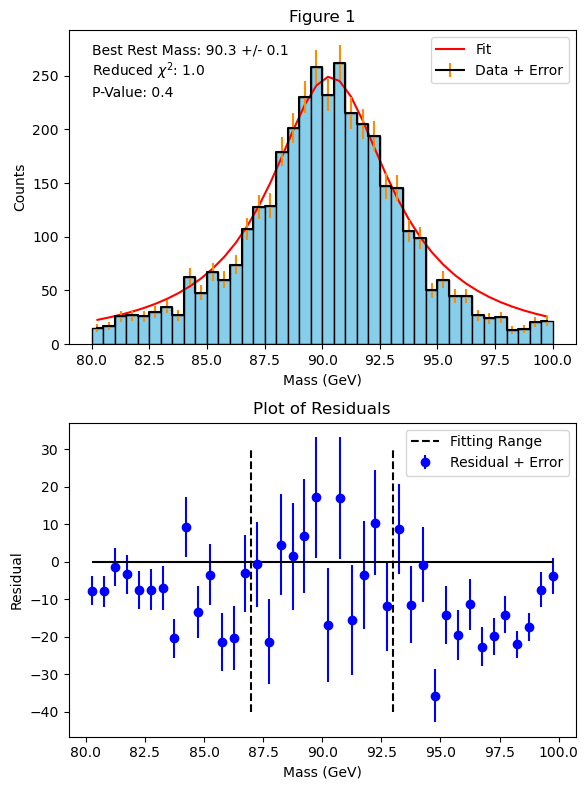

In [13]:
# (1) Breit-Wigner Fit
# Function that will be used to fit the data
def decay(m, m0, T):
    top = (T / 2)
    bottom = np.pi * ((m - m0)**2 + (T / 2)**2)
    # An additional term is introduced to fix normalization
    return (5000 / 2) * (top / bottom)

# Creating mask 
mask = (bin_center > 87) & (bin_center < 93)

# (2) Using 'curve_fit' to fit the data with the function
params, covar = curve_fit(decay, bin_center[mask], counts[mask], sigma = error[mask], absolute_sigma = True)
#params, covar = curve_fit(decay, bin_center, counts, sigma = error, absolute_sigma = True)

# Storing best-fit values
best_m0 = params[0]
best_T = params[1]
# Storing error in best-fit value
m0_error = np.sqrt(np.diag(covar))[0]
T_error = np.sqrt(np.diag(covar))[1]

# Calculating the theory based on the best fit values
theory = decay(bin_center, best_m0, best_T)

# Calculating the residual between the data and theory
residual = (counts - theory)

# (4) Calculating the chi-squared, reduced chi-squared, and p-value
chi_square = np.sum((counts[mask] - theory[mask])**2 / error[mask]**2)
# Finding the degree of freedom by taking the number of data points in mask fit and subtracting the fitting parameters
dof = len(bin_center[mask]) - 2
reduced_chi_square = chi_square / dof
p_value = st.chi2.sf(chi_square, dof)

print(f"""(4) 
Chi-Square: {chi_square}
Reduced Chi Square: {reduced_chi_square}
P-Value: {p_value}\n""")

print(f"""(5)
Best-Fit of True Rest Mass: {best_m0} +/- {m0_error}
Best-Fit of "Width" Parameter: {best_T} +/- {T_error}\n""")

# (3) & (6) Plotting the final plot with data, fit, best rest mass value, reduced chi square, and p-value
fig, (ax_fit, ax_residual) = plt.subplots(2, 1, figsize = (6, 8))
ax_fit.plot(bin_center, theory, color = 'red', label = 'Fit')
ax_fit.errorbar(bin_center, counts, yerr = error, color = 'black', ecolor = 'darkorange', drawstyle = 'steps-mid', label = 'Data + Error')
ax_fit.hist(mass, bins = num_bins, color = 'skyblue', edgecolor = 'black')
# Using 'text' to display the best rest mass value, reduced chi square, and p-value in the plot
ax_fit.text(80, 270, f"Best Rest Mass: {best_m0:.1f} +/- {m0_error:.1f}")
ax_fit.text(80, 250, rf"Reduced $\chi^2$: {reduced_chi_square:.1f}")
ax_fit.text(80, 230, f"P-Value: {p_value:.1f}")
ax_fit.set_xlabel("Mass (GeV)")
ax_fit.set_ylabel("Counts")
ax_fit.set_title("Figure 1")
ax_fit.legend()

# Plotting the residual
ax_residual.errorbar(bin_center, residual, yerr = error, fmt = 'o', color = 'blue', label = 'Residual + Error')
# Drawing a solid horizontal line representing perfect agreement
ax_residual.hlines(0, min(bin_center), max(bin_center), color = 'black')
# Drawing two dotted vertical lines representing the fitting range
ax_residual.vlines(87, -40, 30, ls = '--', color = 'black', label = 'Fitting Range')
ax_residual.vlines(93, -40, 30, ls = '--', color = 'black')
ax_residual.set_xlabel("Mass (GeV)")
ax_residual.set_ylabel("Residual")
ax_residual.set_title("Plot of Residuals")
ax_residual.legend()
fig.tight_layout()

# Part 3: 2D Parameter Contours
___

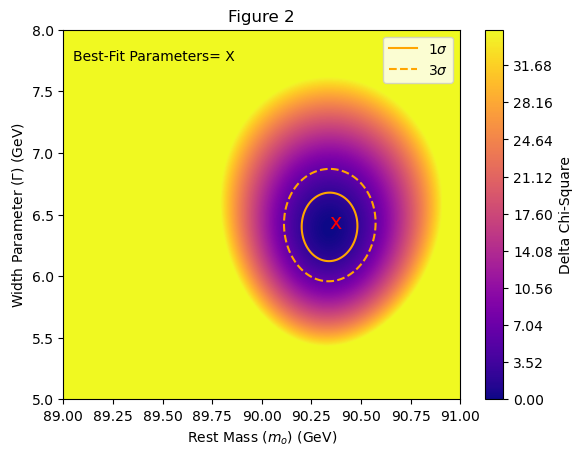

In [9]:
# Initializing variables to perform 2Dchi-squre scan
n_bins = 300
chi_map = np.zeros((n_bins, n_bins))
m0 = np.linspace(89, 91, n_bins)
T = np.linspace(5, 8, n_bins)

# (1) Using double 'for' loop to scan over different values for the fitted parameters
for i in range(n_bins):
    for j in range(n_bins):
        theory = decay(bin_center, m0[i], T[j])
        chi2 = np.sum((theory[mask] - counts[mask])**2 / error[mask]**2)
        chi_map[j, i] = chi2

# (2) Calculating the delta chi-square
chi_min = np.min(chi_map)
chi_map = np.clip(chi_map, chi_min, chi_min + 35)
delta_chi_map = chi_map - chi_min

# Initializing messgrid and plotting 2D contour plot of thedelta chi-square
X, Y = np.meshgrid(m0, T)
fig, ax_2d = plt.subplots(1, 1)
cs = ax_2d.contourf(X, Y, delta_chi_map, 500, cmap = "plasma")
cbar = fig.colorbar(cs, ax = ax_2d)
cbar.set_label("Delta Chi-Square")

# (3) Adding the sigma levels to th 2D contour plots
CS = ax_2d.contour(X, Y, delta_chi_map, levels = [2.3, 6.17], colors = ['orange', 'orange'], linestyles = ["solid", "dashed"])
ax_2d.plot(90.25, 5.5, ls = 'solid', color = 'orange', label = r'1$\sigma$')
ax_2d.plot(90.25, 5.5, ls = 'dashed', color = 'orange', label = r'3$\sigma$')
# (4) Adding an 'X' to the plot to mark where the best fit paramters are
ax_2d.text(best_m0, best_T, 'x', fontsize = '15', color = 'red')
ax_2d.text(89.05, 7.75, 'Best-Fit Parameters= X', fontsize = '10')
ax_2d.set_xlabel(r"Rest Mass ($m_o$) (GeV)")
ax_2d.set_ylabel(r"Width Parameter ($\Gamma$) (GeV)")
ax_2d.set_title("Figure 2")
ax_2d.legend()